<a href="https://colab.research.google.com/github/nrclaudio/1000Genomes-cloud-computing/blob/master/ML4LS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning for Life Sciences: Hands-on session
The [Diabetes130US](https://www.openml.org/d/4541) analyzes factors related to readmission as well as other outcomes pertaining to patients with diabetes. The dataset represents 10 years (1999-2008) of clinical care at 130 US hospitals and integrated delivery networks. It includes over 50 features representing patient and hospital outcomes. Our task is to build a classification model that predicts whether a given patient will be readmitted, and if so, whether they will be readmitted within 30 days or not.

## Installation and imports

In [ ]:
# OpenML is not yet installed by default in Colab. Run once.
!pip install openml --quiet

     |████████████████████████████████| 163kB 4.4MB/s 


In [ ]:
# Same for category-encoders
!pip install category_encoders --quiet

     |████████████████████████████████| 81kB 3.1MB/s 


In [ ]:
# imports
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import openml
import sklearn
import category_encoders
import seaborn

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Loading and preparing data

In [ ]:
# Download Diabetes dataset from OpenML.
# Note that X is a pandas dataframe
dates = openml.datasets.get_dataset(4541)
X, yc, _, feat_names = dates.get_data(target=dates.default_target_attribute)

In [ ]:
X

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide.metformin,glipizide.metformin,glimepiride.pioglitazone,metformin.rosiglitazone,metformin.pioglitazone,change,diabetesMed
0,2278392.0,8222157.0,Caucasian,Female,[0-10),?,6.0,25.0,1.0,1.0,?,Pediatrics-Endocrinology,41.0,0.0,1.0,0.0,0.0,0.0,250.83,?,?,1.0,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No
1,149190.0,55629189.0,Caucasian,Female,[10-20),?,1.0,1.0,7.0,3.0,?,?,59.0,0.0,18.0,0.0,0.0,0.0,276,250.01,255,9.0,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes
2,64410.0,86047875.0,AfricanAmerican,Female,[20-30),?,1.0,1.0,7.0,2.0,?,?,11.0,5.0,13.0,2.0,0.0,1.0,648,250,V27,6.0,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes
3,500364.0,82442376.0,Caucasian,Male,[30-40),?,1.0,1.0,7.0,2.0,?,?,44.0,1.0,16.0,0.0,0.0,0.0,8,250.43,403,7.0,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes
4,16680.0,42519267.0,Caucasian,Male,[40-50),?,1.0,1.0,7.0,1.0,?,?,51.0,0.0,8.0,0.0,0.0,0.0,197,157,250,5.0,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,443847548.0,100162476.0,AfricanAmerican,Male,[70-80),?,1.0,3.0,7.0,3.0,MC,?,51.0,0.0,16.0,0.0,0.0,0.0,250.13,291,458,9.0,None,>8,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Down,No,No,No,No,No,Ch,Yes
101762,443847782.0,74694222.0,AfricanAmerican,Female,[80-90),?,1.0,4.0,5.0,5.0,MC,?,33.0,3.0,18.0,0.0,0.0,1.0,560,276,787,9.0,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes
101763,443854148.0,41088789.0,Caucasian,Male,[70-80),?,1.0,1.0,7.0,1.0,MC,?,53.0,0.0,9.0,1.0,0.0,0.0,38,590,296,13.0,None,None,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Down,No,No,No,No,No,Ch,Yes
101764,443857166.0,31693671.0,Caucasian,Female,[80-90),?,2.0,3.0,7.0,10.0,MC,Surgery-General,45.0,2.0,21.0,0.0,0.0,1.0,996,285,998,9.0,None,None,No,No,No,No,No,No,Steady,No,No,Steady,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes


#### Encode target feature

In [ ]:
# Use category encoding for the target feature
y = yc.cat.codes

# Class names (for nicer plotting)
classes = ['<30','>30','No']

y[0:30], yc[0:30]

(0     2
 1     1
 2     2
 3     2
 4     2
 5     1
 6     2
 7     1
 8     2
 9     2
 10    1
 11    0
 12    0
 13    2
 14    1
 15    2
 16    0
 17    2
 18    1
 19    2
 20    2
 21    2
 22    2
 23    1
 24    2
 25    2
 26    2
 27    1
 28    1
 29    1
 dtype: int8, 0      NO
 1     >30
 2      NO
 3      NO
 4      NO
 5     >30
 6      NO
 7     >30
 8      NO
 9      NO
 10    >30
 11    <30
 12    <30
 13     NO
 14    >30
 15     NO
 16    <30
 17     NO
 18    >30
 19     NO
 20     NO
 21     NO
 22     NO
 23    >30
 24     NO
 25     NO
 26     NO
 27    >30
 28    >30
 29    >30
 Name: readmitted, dtype: category
 Categories (3, object): [<30 < >30 < NO])

#### Special features and values
- `patient_nbr` groups multiple observations from the same patient. This features must not be given to the classifier, but should be used to correctly split the data in train and test sets.
- row ID columns and columns with only 1 value are useless to a classifier. Remove.
- Missing values are often indicated with '?'. Turn these into NaNs.

In [ ]:
# patient_nbr
groups = X['patient_nbr']
# Remove columns with row IDs or with only one value
X = X[[c for c in X.columns if (c.lower() not in ['encounter_id','examide','citoglipton', 'patient_nbr'])]]
# Missing values encoded as '?' with NaN.
X = X.replace('?', np.nan)

Split the categorical from the numeric features.

In [ ]:
# This will be helpful for preprocessing
# The list of the names of all categorical features
categorical = X.select_dtypes(include=["category"]).columns.tolist()
# The list of the names of all numerical features
numerical = X.select_dtypes(exclude=["category"]).columns.tolist()

In [ ]:
categorical

['race',
 'gender',
 'age',
 'weight',
 'payer_code',
 'medical_specialty',
 'diag_1',
 'diag_2',
 'diag_3',
 'max_glu_serum',
 'A1Cresult',
 'metformin',
 'repaglinide',
 'nateglinide',
 'chlorpropamide',
 'glimepiride',
 'acetohexamide',
 'glipizide',
 'glyburide',
 'tolbutamide',
 'pioglitazone',
 'rosiglitazone',
 'acarbose',
 'miglitol',
 'troglitazone',
 'tolazamide',
 'insulin',
 'glyburide.metformin',
 'glipizide.metformin',
 'glimepiride.pioglitazone',
 'metformin.rosiglitazone',
 'metformin.pioglitazone',
 'change',
 'diabetesMed']

## Exploring the data
We first do some simple analysis to get a better view on the data distribution. Feel free to do additional analysis.

In [ ]:
# Peek at the remaining data
X

,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,insulin,glyburide.metformin,glipizide.metformin,glimepiride.pioglitazone,metformin.rosiglitazone,metformin.pioglitazone,change,diabetesMed
0,Caucasian,Female,[0-10),NaN,6.0,25.0,1.0,1.0,NaN,Pediatrics-Endocrinology,41.0,0.0,1.0,0.0,0.0,0.0,250.83,NaN,NaN,1.0,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No
1,Caucasian,Female,[10-20),NaN,1.0,1.0,7.0,3.0,NaN,NaN,59.0,0.0,18.0,0.0,0.0,0.0,276,250.01,255,9.0,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes
2,AfricanAmerican,Female,[20-30),NaN,1.0,1.0,7.0,2.0,NaN,NaN,11.0,5.0,13.0,2.0,0.0,1.0,648,250,V27,6.0,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes
3,Caucasian,Male,[30-40),NaN,1.0,1.0,7.0,2.0,NaN,NaN,44.0,1.0,16.0,0.0,0.0,0.0,8,250.43,403,7.0,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes
4,Caucasian,Male,[40-50),NaN,1.0,1.0,7.0,1.0,NaN,NaN,51.0,0.0,8.0,0.0,0.0,0.0,197,157,250,5.0,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,AfricanAmerican,Male,[70-80),NaN,1.0,3.0,7.0,3.0,MC,NaN,51.0,0.0,16.0,0.0,0.0,0.0,250.13,291,458,9.0,None,>8,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Down,No,No,No,No,No,Ch,Yes
101762,AfricanAmerican,Female,[80-90),NaN,1.0,4.0,5.0,5.0,MC,NaN,33.0,3.0,18.0,0.0,0.0,1.0,560,276,787,9.0,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes
101763,Caucasian,Male,[70-80),NaN,1.0,1.0,7.0,1.0,MC,NaN,53.0,0.0,9.0,1.0,0.0,0.0,38,590,296,13.0,None,None,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Down,No,No,No,No,No,Ch,Yes
101764,Caucasian,Female,[80-90),NaN,2.0,3.0,7.0,10.0,MC,Surgery-General,45.0,2.0,21.0,0.0,0.0,1.0,996,285,998,9.0,None,None,No,No,No,No,No,No,Steady,No,No,Steady,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes


### Column data types and missing data
Most features are encoded as categories. 4 features have missing data, we'll need to handle this. Especially weight is often missing.


In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 45 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   race                      99493 non-null   category
 1   gender                    101766 non-null  category
 2   age                       101766 non-null  category
 3   weight                    3197 non-null    category
 4   admission_type_id         101766 non-null  float64 
 5   discharge_disposition_id  101766 non-null  float64 
 6   admission_source_id       101766 non-null  float64 
 7   time_in_hospital          101766 non-null  float64 
 8   payer_code                61510 non-null   category
 9   medical_specialty         51817 non-null   category
 10  num_lab_procedures        101766 non-null  float64 
 11  num_procedures            101766 non-null  float64 
 12  num_medications           101766 non-null  float64 
 13  number_outpatient         101

### Distribution of categorical features
Some of these are very skewed

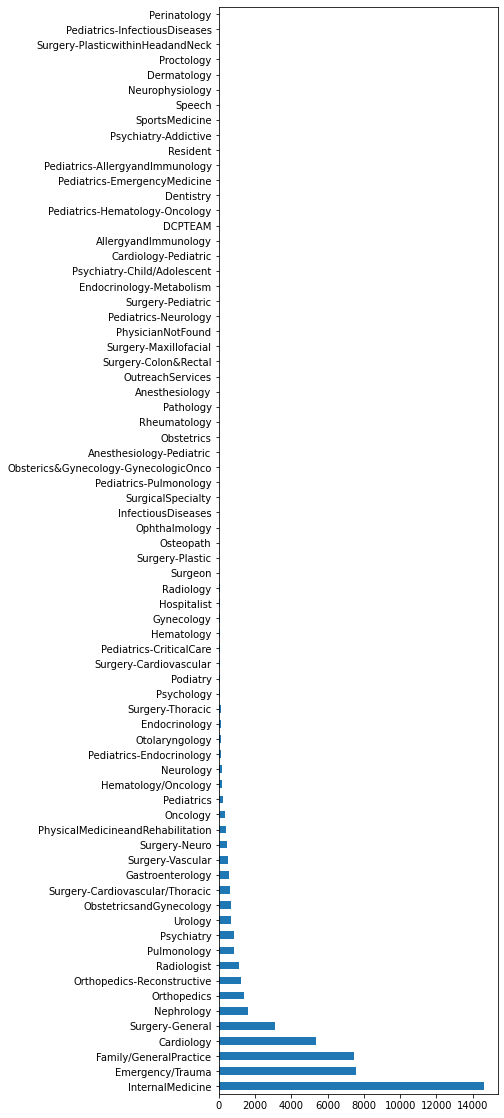

In [ ]:
# Specialty of the admitting physician
X['medical_specialty'].value_counts().plot(kind='barh', figsize=(5,20));

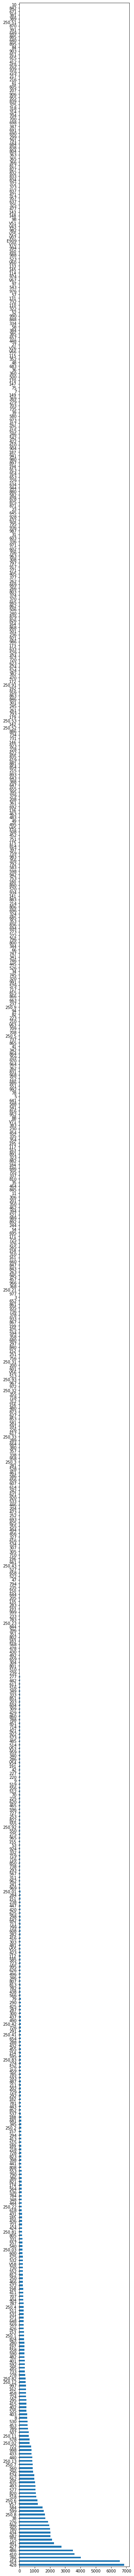

In [ ]:
# Primary diagnosis. These are medical codes. Very skewed, and many possible categories. You don't want to one-hot encode these.
X['diag_1'].value_counts().plot(kind='barh', figsize=(5,120));

### Distribution of numeric features
Some are somewhat skewed. All these are integer values, and often IDs.
Likely, some of these should be encoded as categories, not numeric values.

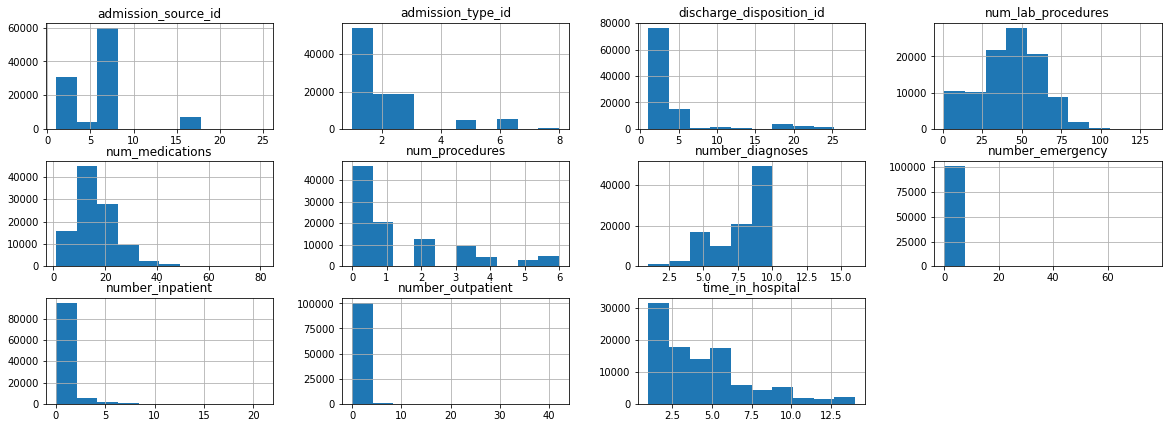

In [ ]:
X.hist(layout=(20,4), figsize=(20,50));

### Which features seem related with the outcome?

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


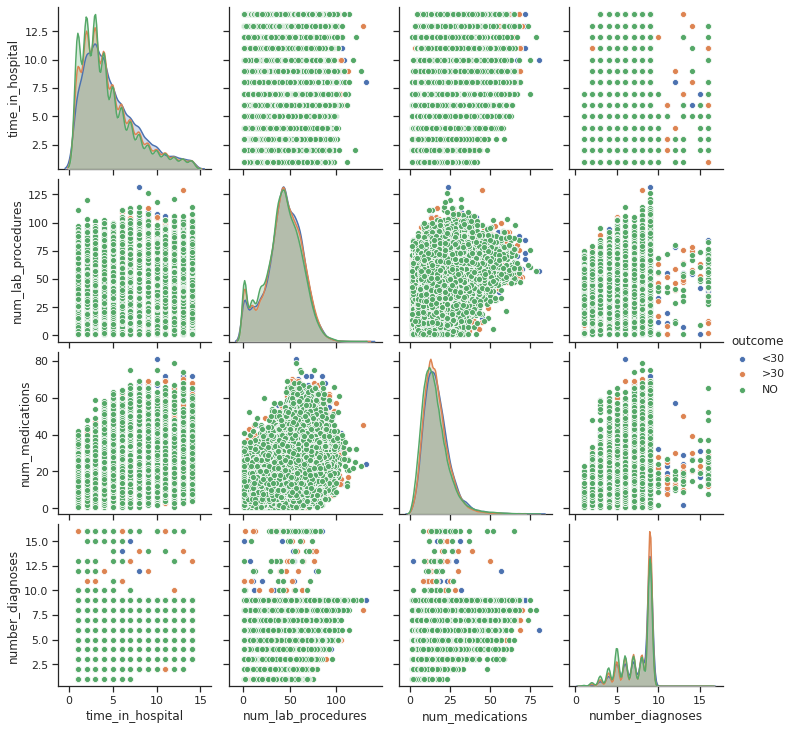

In [ ]:
# Which numeric features seem related with the outcome?
import seaborn as sns
subset = ['time_in_hospital','num_lab_procedures','num_medications','number_diagnoses']
X_sub=X[subset]
X_sub['outcome'] = yc
sns.set(style="ticks")
sns.pairplot(X_sub, hue="outcome");

### Question 1
Implement a function `simple_pipeline` that returns an sklearn pipeline that preprocesses the data in a minimal way before running a classifier:
- Categorical features:
    - Impute missing values by replacing them with the most frequent value for that feature (sklearn.impute.SimpleImputer)
    - Perform one-hot encoding (sklearn.preprocessing.OneHotEncoder
). Use `sparse=False` to avoid that it returns a sparse datasets. Use `handle_unknown='ignore'` to ignore categorical values that where not seen during training.
- Numeric features:
    - Remove missing values by replace missing values with the mean value for that feature

In [ ]:
# Implement
def simple_pipeline(categorical, clf):
    """ Returns a minimal pipeline that imputes missing values and does one-hot-encoding for categorical features
    Keyword arguments:
    categorical -- A list of categorical column names. Example: ['gender', 'country'].
    clf -- any scikit-learn classifier
    Returns: a scikit-learn pipeline which preprocesses the data and then runs the classifier
    """
    pass

In [ ]:
### MODEL SOLUTION
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

def simple_pipeline(categorical, clf):
    cat_pipe = make_pipeline(SimpleImputer(strategy='most_frequent'),OneHotEncoder(sparse=False, handle_unknown='ignore'))
    num_pipe = make_pipeline(SimpleImputer(strategy='mean'))
    transform = make_column_transformer((cat_pipe, categorical), remainder=num_pipe)
    return make_pipeline(transform, clf)

### Question 2
Train the pipeline with a simple decision tree on the diabetes dataset (use the whole dataset as your training set).
How many features are being constructed by this pipeline (i.e. on how many features is the classifier trained)? Why?

In [ ]:
from sklearn.tree import DecisionTreeClassifier
pipe = simple_pipeline(categorical, DecisionTreeClassifier()).fit(X,y);

In [ ]:
# You can use this code. 'pipe' is your fitted pipeline 
print("There are {} features".format(np.shape(pipe.named_steps['columntransformer'].transform(X))[1]))

There are 2461 features


In [ ]:
# Extra: breakdown per type
# One-hot-encoding constructs a new feature per possible category 
print("numeric:",len(numerical))
for f in categorical:
    print("{}: {}".format(f,len(X[f].value_counts())))

numeric: 11
race: 5
gender: 3
age: 10
weight: 9
payer_code: 17
medical_specialty: 72
diag_1: 716
diag_2: 748
diag_3: 789
max_glu_serum: 4
A1Cresult: 4
metformin: 4
repaglinide: 4
nateglinide: 4
chlorpropamide: 4
glimepiride: 4
acetohexamide: 2
glipizide: 4
glyburide: 4
tolbutamide: 2
pioglitazone: 4
rosiglitazone: 4
acarbose: 4
miglitol: 4
troglitazone: 2
tolazamide: 3
insulin: 4
glyburide.metformin: 4
glipizide.metformin: 2
glimepiride.pioglitazone: 2
metformin.rosiglitazone: 2
metformin.pioglitazone: 2
change: 2
diabetesMed: 2


### Question 3
Implement a function `flexible_pipeline` that has two additional options:
- Allow to add a feature scaling method for numeric features. The default is standard scaling. 'None' means no scaling
- Allow the one-hot encoder to be replaced with another encoder, The default is one-hot encoding.
- See the slides on 'Feature Engineering' for additional scalers and encoders.

In [ ]:
# Implement
from sklearn.preprocessing import StandardScaler, OneHotEncoder
def flexible_pipeline(categorical, clf, scaler=StandardScaler(), encoder=OneHotEncoder()):
    """ Returns a pipeline that imputes all missing values, encodes categorical features and scales numeric ones
    Keyword arguments:
    categorical -- A list of categorical column names. Example: ['gender', 'country'].
    clf -- any scikit-learn classifier
    scaler -- any scikit-learn feature scaling method (Optional)
    encoder -- any scikit-learn category encoding method (Optional)
    Returns: a scikit-learn pipeline which preprocesses the data and then runs the classifier
    """
    pass

In [ ]:
def flexible_pipeline(categorical, clf, scaler=StandardScaler(), encoder=OneHotEncoder()):
    cat_pipe = make_pipeline(SimpleImputer(strategy='most_frequent'),encoder)
    num_pipe = make_pipeline(SimpleImputer(strategy='mean'),scaler)
    transform = make_column_transformer((cat_pipe, categorical), remainder=num_pipe)
    return make_pipeline(transform, clf)

### Question 4
Add a very simple classifier to this pipeline, e.g. Logistic Regression or a Decision tree. Evaluate these models (default settings) using a grouped and stratified, 3-fold cross-validation.

In [ ]:
groups = groups.astype(int).astype('category').cat.codes

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GroupKFold, cross_val_score
pipe = flexible_pipeline(categorical, DecisionTreeClassifier(), scaler=StandardScaler(), encoder=OneHotEncoder(sparse=False, handle_unknown='ignore'))
scores = cross_val_score(pipe, X, y, groups, cv=GroupKFold(n_splits=3))

In [ ]:
scores

array([0.49696362, 0.49431048, 0.49602028])

In [ ]:
pipe = flexible_pipeline(categorical, LogisticRegression(), scaler=StandardScaler(), encoder=OneHotEncoder(sparse=False, handle_unknown='ignore'))
scores = cross_val_score(pipe, X, y, groups, cv=GroupKFold(n_splits=3))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


### Question 5
Implement a function `plot_5` which plots a heatmap comparing several combinations of scaling methods and classifiers:
* As classifiers, the following algorithms in their default hyperparameters settings: 
    * Logistic regression
    * SVM with RBF kernel
    * Random Forest
* As options, the following feature scaling options in their default settings:
    * No scaling
    * Standard scaling
    * Normalize
    * PowerTransformer
* In all cases, use OneHotEncoder with `sparse=False` and `handle_unknown='ignore'`
* Which pipelines work best?

You can evaluate all pipelines using Accuracy with 3-fold grouped (and stratified) cross-validation. 
Compare all methods with the same cross-validation folds, shuffle the data and use `random_state=1`.
Where possible, also use `random_state=1` for the classifiers. 
Only report the test scores (not the training scores).

In [ ]:
### Helper plotting function. Do not change.
import seaborn as sns
def heatmap(columns, rows, scores):
    """ Simple heatmap.
    Keyword arguments:
    columns -- list of options in the columns
    rows -- list of options in the rows
    scores -- numpy array of scores
    """
    df = pd.DataFrame(scores, index=rows, columns=columns)
    sns.heatmap(df, cmap='RdYlGn_r', linewidths=0.5, annot=True, fmt=".3f")

In [ ]:
# Implement
def plot_5(X, y):
    """ Evaluates 3 classifiers together with 4 types of scaling. See description above.
    """
    pass

### Question 6
Optimize the encoding method for the categorical features. Use your `flexible_pipeline` to compare OneHotEncoding and TargetEncoding
together with the same 3 classifiers as in question 1.4. Always use standard scaling. Implement a function `plot_6` which plots a heatmap with the results.

TargetEncoding is part of the category encoders extension of scikit-learn. [Read more about it.](https://contrib.scikit-learn.org/categorical-encoding/targetencoder.html)

In [ ]:
from category_encoders import TargetEncoder
# Implement
def plot_6(X, y):
    """ Evaluates 3 classifiers and plots the results in a bar chart.
    Also compares different category encoders
    """
    pass

### Question 7
Use a grid search to optimize the RandomForest pipeline. Vary the number of trees from 100 to 1500 and `max_features` from
0.05 to 0.1. Use at least 2 values for every hyperparameter. Evaluate all pipelines using AUC (area under the ROC curve) with 3-fold cross-validation. Compare all methods with the same cross-validation folds, shuffle the data and use `random_state=1`.
Plot the results in a heatmap in function `plot_7`.

In [ ]:
#Implement
def plot_7(X, y):
    """ See detailed description above.
    """
    pass